In [463]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV



#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [464]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [465]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [466]:
def join_data(observed, estimated, labels):
    #Remove hour and minute values
    observed = observed.assign(date_forecast=observed.date_forecast.dt.round('H'))
    estimated = estimated.assign(date_forecast=estimated.date_forecast.dt.round('H'))
    
    #rename columns names to match
    observed = observed.rename(columns={'date_forecast': 'date'})
    estimated = estimated.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    data = pd.concat([observed, estimated])
    joined_data = pd.merge(data, labels, how="inner", on="date")
    
    return joined_data
    

In [467]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df


In [468]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [469]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [470]:
def feature_date(df):
    df["month"] = [df["date"][i].month for i in range(len(df))]
    df["hour"] = [df["date"][i].hour for i in range(len(df))]
    df.pop('date')


In [471]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [472]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos", "month", "Hour", "pv_measurement"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [473]:
def combine_features(df, features, new_name):
    
    totals = []
    
    for i in range(len(df)):
        total = 1
        for feature in features:
            total *= df[feature][i]
        
        totals.append(total)
            
   
    df.drop(features, axis=1, inplace=True)
    df[new_name] = totals
    df[new_name] = df[new_name] / df[new_name].max()

In [474]:
def split_data(df):
    val_split = 0.15
    val_months = [5, 6, 7]

    len_df = len(df)
    val_length = int(len_df * val_split)

    current_val_indices = []

    for i in range(0, len(df)):
        if int(df["date"][i].month) in val_months:
            current_val_indices.append(i)

        if len(current_val_indices) >= val_length:
            break


    validation_rows = df.iloc[current_val_indices]
    training_rows = df.drop(current_val_indices, axis=0)
    
    
    training_rows = training_rows.reset_index()
    training_rows = training_rows.drop(['index'], axis=1)
    
    validation_rows = validation_rows.reset_index()
    validation_rows = validation_rows.drop(['index'], axis=1)
    
    return training_rows, validation_rows

In [475]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [476]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [477]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [478]:
data_a = join_data(X_train_observed_a, X_train_estimated_a, train_a)
data_b = join_data(X_train_observed_b, X_train_estimated_b, train_b)
data_c = join_data(X_train_observed_c, X_train_estimated_c, train_c)

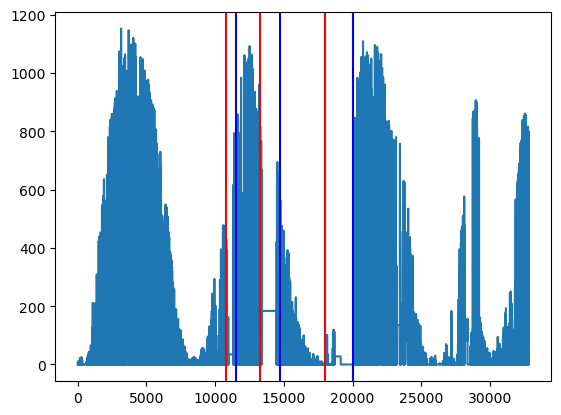

In [479]:
plt.plot(data_b['pv_measurement'])

plt.axvline(x=10800, color="red")
plt.axvline(x=11500, color="blue")

plt.axvline(x=13250, color="red")
plt.axvline(x=14700, color="blue")

plt.axvline(x=18000, color="red")
plt.axvline(x=20000, color="blue")

data_b = data_b.drop(data_b.index[10800:11500])
data_b = data_b.drop(data_b.index[13250:14700])
data_b = data_b.drop(data_b.index[18000:20000])

data_b = data_b.reset_index()
data_b = data_b.drop(['index'], axis=1)

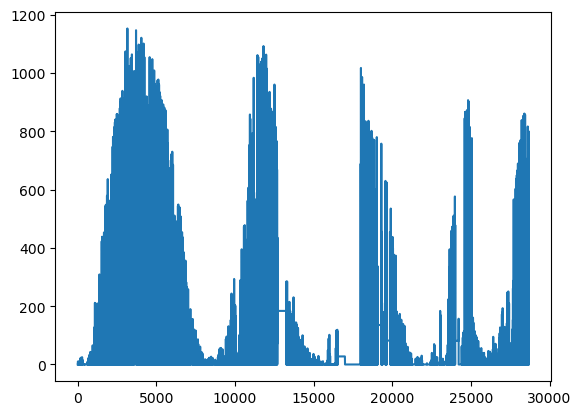

In [480]:
plt.plot(data_b['pv_measurement'])

In [481]:
train_data_a, val_data_a = split_data(data_a)
train_data_b, val_data_b = split_data(data_b)
train_data_c, val_data_c = split_data(data_c)

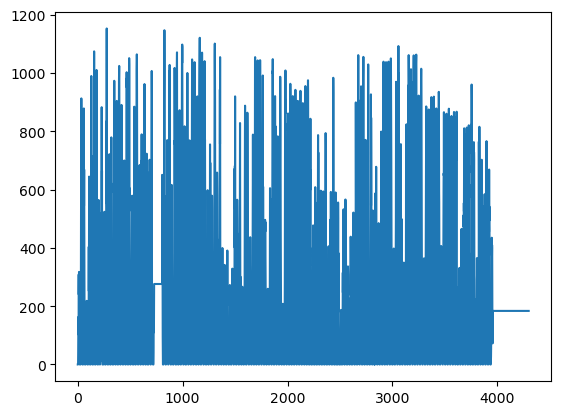

In [482]:
plt.plot(val_data_b['pv_measurement'])

In [110]:
# Remove columns which are not needed
#train_data_a = remove_unused_columns(train_data_a)
#val_data_a = remove_unused_columns(val_data_a)
#test_a = remove_unused_columns(test_a)

#train_data_b = remove_unused_columns(train_data_b)
#val_data_b = remove_unused_columns(val_data_b)
#test_b = remove_unused_columns(test_b)

#train_data_c = remove_unused_columns(train_data_c)
#val_data_c = remove_unused_columns(val_data_c)
#test_c = remove_unused_columns(test_c) 

0      2022-10-28 22:00:00
1      2022-10-28 23:00:00
2      2022-10-29 00:00:00
3      2022-10-29 01:00:00
4      2022-10-29 02:00:00
               ...        
4389   2023-04-30 19:00:00
4390   2023-04-30 20:00:00
4391   2023-04-30 21:00:00
4392   2023-04-30 22:00:00
4393   2023-04-30 23:00:00
Name: date, Length: 4394, dtype: datetime64[ns]

In [68]:
#Convert date into sin and cos components
#convert_date_to_sin_and_cos(train_data_a)
#convert_date_to_sin_and_cos(val_data_a)
#convert_date_to_sin_and_cos(test_a)

#convert_date_to_sin_and_cos(train_data_b)
#convert_date_to_sin_and_cos(val_data_b)
#convert_date_to_sin_and_cos(test_b)

#convert_date_to_sin_and_cos(train_data_c)
#convert_date_to_sin_and_cos(val_data_c)
#convert_date_to_sin_and_cos(test_c)


#Extract date components
feature_date(train_data_a)
feature_date(val_data_a)
feature_date(test_a)

feature_date(train_data_b)
feature_date(val_data_b)
feature_date(test_b)

feature_date(train_data_c)
feature_date(val_data_c)
feature_date(test_c)

In [69]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [70]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [71]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [72]:
#combine_features(train_data_a, ['clear_sky_energy_1h:J', 'clear_sky_rad:W'], 'clear_sky')
#combine_features(val_data_a, ['clear_sky_energy_1h:J', 'clear_sky_rad:W'], 'clear_sky')
#combine_features(test_a, ['clear_sky_energy_1h:J', 'clear_sky_rad:W'], 'clear_sky')

#combine_features(train_data_a, ['relative_humidity_1000hPa:p', 'absolute_humidity_2m:gm3'], 'humidity')
#combine_features(val_data_a, ['relative_humidity_1000hPa:p', 'absolute_humidity_2m:gm3'], 'humidity')
#combine_features(test_a, ['relative_humidity_1000hPa:p', 'absolute_humidity_2m:gm3'], 'humidity')

,count,mean,std,min,25%,50%,75%,max
absolute_humidity_2m:gm3,29667.0,6.652590,2.795383,0.700000,4.450000,6.300000,8.600000e+00,1.735000e+01
air_density_2m:kgm3,29667.0,1.249064,0.036304,1.145000,1.224500,1.246500,1.272500e+00,1.426250e+00
ceiling_height_agl:m,29667.0,2417.717041,2587.863037,0.000000,608.149994,1525.199951,3.333950e+03,1.228565e+04
clear_sky_energy_1h:J,29667.0,599406.750000,877493.062500,0.000000,0.000000,41072.101562,1.025277e+06,2.988628e+06
clear_sky_rad:W,29667.0,166.501816,244.373398,0.000000,0.000000,9.925000,2.917375e+02,8.351000e+02
cloud_base_agl:m,29667.0,1639.017578,1811.001953,0.000000,503.399994,1078.849976,2.003925e+03,1.167362e+04
dew_or_rime:idx,29667.0,0.022399,0.180974,-1.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
dew_point_2m:K,29667.0,276.823364,6.700147,251.074997,272.075012,277.150024,2.819500e+02,2.936250e+02
diffuse_rad:W,29667.0,44.918659,64.514648,0.000000,0.000000,4.750000,7.627500e+01,3.322750e+02
diffuse_rad_1h:J,29667.0,161707.031250,229485.578125,0.000000,0.000000,26047.175781,2.739763e+05,1.191085e+06


In [73]:
train_data_c = train_data_c[5800:]
train_data_b = train_data_b.drop(train_data_b.index[13410:14460])
train_data_b = train_data_b.drop(train_data_b.index[18000:20000])
train_data_b = train_data_b.reset_index()
train_data_c = train_data_c.reset_index()
train_data_b = train_data_b.drop(['index'], axis=1)
train_data_c = train_data_c.drop(['index'], axis=1)

In [74]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [75]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [76]:
import gc
gc.collect()

7460

[22:29:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[22:29:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[22:29:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[22:29:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[22:29:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:542.47049+2.91258	test-mae:542.29178+13.15164
[1]	train-mae:442.63091+2.00399	test-mae:443.26270+10.83170
[2]	train-mae:370.86631+1.66657	test-mae:372.79906+8.22150
[3]	train-mae:320.64463+1.39730	test-mae:323.78285+6.64041
[4]	train-mae:285.83659+0.82531	test-mae:290.04963+5.96503
[5]

[22]	validation_0-mae:192.26398	validation_1-mae:128.50339
[23]	validation_0-mae:191.54597	validation_1-mae:128.73009
[24]	validation_0-mae:190.96843	validation_1-mae:128.73856
[25]	validation_0-mae:190.25984	validation_1-mae:128.66448
[26]	validation_0-mae:189.94554	validation_1-mae:128.35854
[27]	validation_0-mae:189.86671	validation_1-mae:128.78753
[28]	validation_0-mae:189.61008	validation_1-mae:129.45636
[29]	validation_0-mae:189.82474	validation_1-mae:130.32269
[30]	validation_0-mae:188.93093	validation_1-mae:129.79414
[31]	validation_0-mae:188.87945	validation_1-mae:130.10944
[32]	validation_0-mae:187.75109	validation_1-mae:129.71627
[33]	validation_0-mae:186.92940	validation_1-mae:129.67965
[34]	validation_0-mae:186.15465	validation_1-mae:128.87610
[35]	validation_0-mae:185.32680	validation_1-mae:128.34972
[36]	validation_0-mae:184.95869	validation_1-mae:128.31568
[37]	validation_0-mae:184.78521	validation_1-mae:128.38138
[38]	validation_0-mae:184.16751	validation_1-mae:128.149

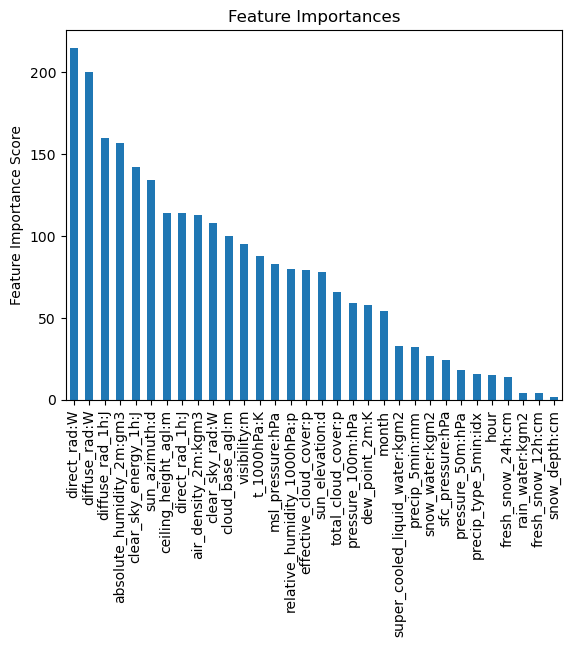

In [77]:
model_a = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
)


#model_a = xgb.XGBRegressor(
# device='cuda',
# learning_rate =0.05,
# n_estimators=208,
# max_depth=7,
# min_child_weight=6,
# gamma=0.0,
# subsample=0.75,
# colsample_bytree=0.85,
# nthread=4,
# seed=42,
# eval_metric= 'mae',
# scale_pos_weight=1,
# booster='gbtree',
# reg_alpha=99
#)
#147.11169339319093 164.9524087949787 -> combination
#177.78683230658893 142.8104573672486 -> normalized
#161.01663173887053 128.3410515641189



#base: 111.09641204863941 124.56255801196808
#65.99057396142592 125.93691245063847 n=738
#131.64369181722458 122.00666540716254 n=208
modelfit(model_a, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = True)

[0]	train-mae:128.35259+1.16215	test-mae:128.36672+2.52974
[1]	train-mae:123.38063+1.11948	test-mae:123.41569+2.45182
[2]	train-mae:118.71801+1.07091	test-mae:118.75110+2.37629
[3]	train-mae:114.35248+1.04251	test-mae:114.41489+2.27723
[4]	train-mae:110.28594+0.95705	test-mae:110.34534+2.23440
[5]	train-mae:106.46676+0.88575	test-mae:106.52977+2.20441
[6]	train-mae:102.89831+0.87312	test-mae:102.94263+2.09596
[7]	train-mae:99.51860+0.82277	test-mae:99.57291+2.02466
[8]	train-mae:96.37976+0.80887	test-mae:96.45350+1.93335
[9]	train-mae:93.36008+0.75865	test-mae:93.40981+1.88506
[10]	train-mae:90.46516+0.72161	test-mae:90.55849+1.84828
[11]	train-mae:87.76868+0.71334	test-mae:87.88463+1.74383
[12]	train-mae:85.22828+0.71792	test-mae:85.37056+1.65078
[13]	train-mae:82.84014+0.65322	test-mae:83.00929+1.62810
[14]	train-mae:80.51971+0.60877	test-mae:80.68823+1.56205
[15]	train-mae:78.39308+0.55458	test-mae:78.55471+1.55729
[16]	train-mae:76.37048+0.54178	test-mae:76.53614+1.53732
[17]	train

[141]	train-mae:37.92506+0.21488	test-mae:38.54790+0.44868
[142]	train-mae:37.92055+0.22105	test-mae:38.54331+0.43932
[143]	train-mae:37.91091+0.20910	test-mae:38.53166+0.44805
[144]	train-mae:37.90560+0.21343	test-mae:38.53025+0.44627
[145]	train-mae:37.89705+0.22572	test-mae:38.52573+0.43068
[146]	train-mae:37.87598+0.20638	test-mae:38.50902+0.44701
[147]	train-mae:37.86544+0.20409	test-mae:38.50374+0.44976
[148]	train-mae:37.84940+0.20766	test-mae:38.49191+0.44977
[149]	train-mae:37.84834+0.20867	test-mae:38.49385+0.44620
[150]	train-mae:37.82548+0.20281	test-mae:38.47213+0.44825
[151]	train-mae:37.79517+0.18912	test-mae:38.44350+0.46350
[152]	train-mae:37.79504+0.20154	test-mae:38.44422+0.45223
[153]	train-mae:37.78600+0.20972	test-mae:38.43733+0.44377
[154]	train-mae:37.78953+0.20468	test-mae:38.44278+0.44645
[155]	train-mae:37.76954+0.20764	test-mae:38.42699+0.44890
[156]	train-mae:37.75568+0.20141	test-mae:38.41231+0.45419
[157]	train-mae:37.75377+0.20191	test-mae:38.41500+0.450

[280]	train-mae:36.91783+0.22104	test-mae:37.92470+0.41115
[281]	train-mae:36.90876+0.21915	test-mae:37.91805+0.41566
[282]	train-mae:36.90795+0.22034	test-mae:37.91965+0.41470
[283]	train-mae:36.89506+0.21942	test-mae:37.90815+0.41305
[284]	train-mae:36.88937+0.22009	test-mae:37.90313+0.40992
[285]	train-mae:36.88292+0.23128	test-mae:37.89628+0.40391
[286]	train-mae:36.87039+0.23344	test-mae:37.88684+0.40514
[287]	train-mae:36.86321+0.23173	test-mae:37.88139+0.40465
[288]	train-mae:36.85653+0.23281	test-mae:37.87695+0.39882
[289]	train-mae:36.85170+0.22616	test-mae:37.87649+0.40388
[290]	train-mae:36.84561+0.22163	test-mae:37.87327+0.40741
[291]	train-mae:36.83994+0.22107	test-mae:37.86912+0.40925
[292]	train-mae:36.83632+0.22301	test-mae:37.86848+0.40948
[293]	train-mae:36.82630+0.22151	test-mae:37.85850+0.41303
[294]	train-mae:36.81959+0.22133	test-mae:37.85815+0.41298
[295]	train-mae:36.81936+0.21973	test-mae:37.86306+0.41502
[296]	train-mae:36.80812+0.22044	test-mae:37.85341+0.411

[419]	train-mae:36.18311+0.19898	test-mae:37.49922+0.39701
[420]	train-mae:36.16761+0.19221	test-mae:37.48288+0.40459
[421]	train-mae:36.16541+0.19038	test-mae:37.48051+0.40541
[422]	train-mae:36.16030+0.18552	test-mae:37.48040+0.40863
[423]	train-mae:36.15967+0.18708	test-mae:37.48302+0.40821
[424]	train-mae:36.15756+0.18655	test-mae:37.48251+0.40696
[425]	train-mae:36.16046+0.18750	test-mae:37.48682+0.40562
[426]	train-mae:36.14863+0.18498	test-mae:37.47780+0.41093
[427]	train-mae:36.14992+0.18830	test-mae:37.47813+0.40758
[428]	train-mae:36.14557+0.18691	test-mae:37.47615+0.40823
[429]	train-mae:36.14044+0.18742	test-mae:37.47216+0.40744
[430]	train-mae:36.13700+0.18705	test-mae:37.47114+0.40793
[431]	train-mae:36.13346+0.18968	test-mae:37.46853+0.40486
[432]	train-mae:36.12955+0.19271	test-mae:37.46487+0.40182
[433]	train-mae:36.12294+0.19099	test-mae:37.46179+0.40255
[434]	train-mae:36.11607+0.18875	test-mae:37.45858+0.40600
[435]	train-mae:36.11100+0.18860	test-mae:37.45827+0.405

[558]	train-mae:35.53108+0.21356	test-mae:37.11583+0.40832
[559]	train-mae:35.52621+0.21042	test-mae:37.11287+0.41065
[560]	train-mae:35.52247+0.20807	test-mae:37.11092+0.41422
[561]	train-mae:35.51344+0.21101	test-mae:37.10258+0.41065
[562]	train-mae:35.51037+0.21056	test-mae:37.09928+0.40957
[563]	train-mae:35.50711+0.21013	test-mae:37.09466+0.40954
[564]	train-mae:35.50294+0.21349	test-mae:37.09154+0.40718
[565]	train-mae:35.49873+0.21164	test-mae:37.09121+0.41069
[566]	train-mae:35.49258+0.21289	test-mae:37.08467+0.40701
[567]	train-mae:35.48338+0.21399	test-mae:37.07464+0.40349
[568]	train-mae:35.47960+0.21396	test-mae:37.07424+0.40266
[569]	train-mae:35.47759+0.21278	test-mae:37.07669+0.40268
[570]	train-mae:35.47741+0.21174	test-mae:37.07850+0.40289
[571]	train-mae:35.47283+0.21063	test-mae:37.07595+0.40628
[572]	train-mae:35.46701+0.21046	test-mae:37.06993+0.40711
[573]	train-mae:35.46700+0.21016	test-mae:37.07111+0.40750
[574]	train-mae:35.46403+0.20848	test-mae:37.07178+0.409

[697]	train-mae:35.02894+0.22418	test-mae:36.85609+0.41790
[698]	train-mae:35.02702+0.22814	test-mae:36.85529+0.41462
[699]	train-mae:35.02264+0.23017	test-mae:36.85391+0.41698
[700]	train-mae:35.01638+0.23392	test-mae:36.84854+0.41445
[701]	train-mae:35.00944+0.23070	test-mae:36.84597+0.41590
[702]	train-mae:35.00670+0.23429	test-mae:36.84451+0.41270
[703]	train-mae:35.00436+0.23823	test-mae:36.84308+0.40800
[704]	train-mae:35.00337+0.23729	test-mae:36.84328+0.40773
[705]	train-mae:34.99838+0.23758	test-mae:36.83989+0.40825
[706]	train-mae:34.99752+0.23933	test-mae:36.84065+0.40672
[707]	train-mae:34.99426+0.24074	test-mae:36.84002+0.40749
[708]	train-mae:34.99644+0.23728	test-mae:36.84285+0.40997
[709]	train-mae:34.99782+0.23251	test-mae:36.84661+0.41640
[710]	train-mae:34.99456+0.23387	test-mae:36.84825+0.41485
[711]	train-mae:34.98883+0.23199	test-mae:36.84622+0.41869
[712]	train-mae:34.98425+0.23447	test-mae:36.84302+0.41465
[713]	train-mae:34.97881+0.23973	test-mae:36.83848+0.407

[836]	train-mae:34.53030+0.24032	test-mae:36.60484+0.41222
[837]	train-mae:34.52571+0.23423	test-mae:36.60304+0.41947
[838]	train-mae:34.52014+0.23703	test-mae:36.59802+0.41401
[839]	train-mae:34.51908+0.24012	test-mae:36.60044+0.41239
[840]	train-mae:34.51819+0.24000	test-mae:36.60224+0.41343
[841]	train-mae:34.51824+0.23966	test-mae:36.60495+0.41166
[842]	train-mae:34.51607+0.24027	test-mae:36.60587+0.41191
[843]	train-mae:34.51333+0.24026	test-mae:36.60366+0.41345
[844]	train-mae:34.51170+0.24121	test-mae:36.60354+0.41364
[845]	train-mae:34.51015+0.24106	test-mae:36.60432+0.41222
[846]	train-mae:34.50500+0.24387	test-mae:36.60228+0.40966
[847]	train-mae:34.49994+0.24231	test-mae:36.59967+0.41032
[0]	validation_0-mae:128.36133	validation_1-mae:106.45507
[1]	validation_0-mae:123.39959	validation_1-mae:102.07633
[2]	validation_0-mae:118.73057	validation_1-mae:97.73777
[3]	validation_0-mae:114.44041	validation_1-mae:93.93466
[4]	validation_0-mae:110.36383	validation_1-mae:90.23770
[5]	v

[131]	validation_0-mae:38.11227	validation_1-mae:23.36495
[132]	validation_0-mae:38.09119	validation_1-mae:23.36926
[133]	validation_0-mae:38.04150	validation_1-mae:23.27159
[134]	validation_0-mae:38.04031	validation_1-mae:23.30503
[135]	validation_0-mae:38.04963	validation_1-mae:23.30902
[136]	validation_0-mae:38.06841	validation_1-mae:23.34859
[137]	validation_0-mae:38.06318	validation_1-mae:23.34866
[138]	validation_0-mae:38.06020	validation_1-mae:23.35442
[139]	validation_0-mae:38.05024	validation_1-mae:23.35808
[140]	validation_0-mae:38.05242	validation_1-mae:23.34412
[141]	validation_0-mae:38.03868	validation_1-mae:23.33764
[142]	validation_0-mae:38.01823	validation_1-mae:23.32445
[143]	validation_0-mae:38.01797	validation_1-mae:23.32805
[144]	validation_0-mae:37.99602	validation_1-mae:23.31874
[145]	validation_0-mae:37.98289	validation_1-mae:23.33134
[146]	validation_0-mae:37.97533	validation_1-mae:23.32492
[147]	validation_0-mae:37.95786	validation_1-mae:23.29629
[148]	validati

[273]	validation_0-mae:36.87638	validation_1-mae:23.01569
[274]	validation_0-mae:36.87021	validation_1-mae:23.00248
[275]	validation_0-mae:36.86132	validation_1-mae:22.99755
[276]	validation_0-mae:36.85764	validation_1-mae:22.99951
[277]	validation_0-mae:36.85786	validation_1-mae:23.00569
[278]	validation_0-mae:36.85113	validation_1-mae:22.99111
[279]	validation_0-mae:36.86019	validation_1-mae:23.01022
[280]	validation_0-mae:36.83842	validation_1-mae:23.02761
[281]	validation_0-mae:36.83211	validation_1-mae:23.02776
[282]	validation_0-mae:36.83040	validation_1-mae:23.00485
[283]	validation_0-mae:36.82829	validation_1-mae:23.00047
[284]	validation_0-mae:36.79899	validation_1-mae:22.95144
[285]	validation_0-mae:36.79592	validation_1-mae:22.95183
[286]	validation_0-mae:36.80069	validation_1-mae:22.95433
[287]	validation_0-mae:36.78917	validation_1-mae:22.95573
[288]	validation_0-mae:36.79149	validation_1-mae:22.96332
[289]	validation_0-mae:36.78816	validation_1-mae:22.96443
[290]	validati

[415]	validation_0-mae:36.23332	validation_1-mae:22.78876
[416]	validation_0-mae:36.24011	validation_1-mae:22.79476
[417]	validation_0-mae:36.24185	validation_1-mae:22.81096
[418]	validation_0-mae:36.23967	validation_1-mae:22.81074
[419]	validation_0-mae:36.23197	validation_1-mae:22.79193
[420]	validation_0-mae:36.22686	validation_1-mae:22.78690
[421]	validation_0-mae:36.21928	validation_1-mae:22.77898
[422]	validation_0-mae:36.21638	validation_1-mae:22.78264
[423]	validation_0-mae:36.21013	validation_1-mae:22.78169
[424]	validation_0-mae:36.21539	validation_1-mae:22.78725
[425]	validation_0-mae:36.20774	validation_1-mae:22.77773
[426]	validation_0-mae:36.20913	validation_1-mae:22.78160
[427]	validation_0-mae:36.20881	validation_1-mae:22.78193
[428]	validation_0-mae:36.20017	validation_1-mae:22.78060
[429]	validation_0-mae:36.19882	validation_1-mae:22.78087
[430]	validation_0-mae:36.20214	validation_1-mae:22.79526
[431]	validation_0-mae:36.20106	validation_1-mae:22.79908
[432]	validati

[557]	validation_0-mae:35.72532	validation_1-mae:22.64750
[558]	validation_0-mae:35.72015	validation_1-mae:22.64646
[559]	validation_0-mae:35.70954	validation_1-mae:22.64357
[560]	validation_0-mae:35.69930	validation_1-mae:22.61184
[561]	validation_0-mae:35.69813	validation_1-mae:22.60089
[562]	validation_0-mae:35.67889	validation_1-mae:22.58340
[563]	validation_0-mae:35.67299	validation_1-mae:22.59653
[564]	validation_0-mae:35.67534	validation_1-mae:22.59823
[565]	validation_0-mae:35.67439	validation_1-mae:22.59820
[566]	validation_0-mae:35.66451	validation_1-mae:22.60371
[567]	validation_0-mae:35.66016	validation_1-mae:22.60318
[568]	validation_0-mae:35.64986	validation_1-mae:22.58511
[569]	validation_0-mae:35.65022	validation_1-mae:22.57993
[570]	validation_0-mae:35.64747	validation_1-mae:22.59370
[571]	validation_0-mae:35.64568	validation_1-mae:22.58879
[572]	validation_0-mae:35.63795	validation_1-mae:22.58287
[573]	validation_0-mae:35.64353	validation_1-mae:22.59424
[574]	validati

[699]	validation_0-mae:35.15358	validation_1-mae:22.37282
[700]	validation_0-mae:35.14889	validation_1-mae:22.37189
[701]	validation_0-mae:35.14947	validation_1-mae:22.37043
[702]	validation_0-mae:35.14425	validation_1-mae:22.37006
[703]	validation_0-mae:35.14133	validation_1-mae:22.37042
[704]	validation_0-mae:35.14171	validation_1-mae:22.37331
[705]	validation_0-mae:35.14354	validation_1-mae:22.37405
[706]	validation_0-mae:35.13850	validation_1-mae:22.36998
[707]	validation_0-mae:35.13690	validation_1-mae:22.38938
[708]	validation_0-mae:35.12591	validation_1-mae:22.39086
[709]	validation_0-mae:35.12703	validation_1-mae:22.39293
[710]	validation_0-mae:35.12295	validation_1-mae:22.38251
[711]	validation_0-mae:35.12547	validation_1-mae:22.41278
[712]	validation_0-mae:35.12561	validation_1-mae:22.41339
[713]	validation_0-mae:35.11935	validation_1-mae:22.41011
[714]	validation_0-mae:35.11700	validation_1-mae:22.41203
[715]	validation_0-mae:35.11742	validation_1-mae:22.41047
[716]	validati

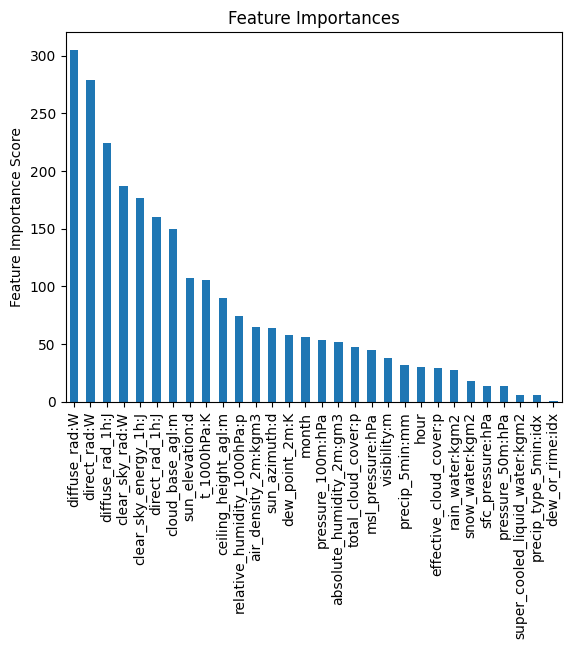

In [223]:
model_b = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=838,
 max_depth=2,
 min_child_weight=6,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha= 0.05, 
 reg_lambda= 1
)

#14.594442962612668 23.10780024288535 n=362
#35.26892921016903 22.888491212842357 n=206
#34.76734101188924 22.512291094037696 n= 838

modelfit(model_b, train_data_b, train_b_y, val_data_b, val_b_y, useTrainCV = False)

[0]	validation_0-mae:109.39256	validation_1-mae:84.14437
[1]	validation_0-mae:104.67749	validation_1-mae:80.43491
[2]	validation_0-mae:100.18614	validation_1-mae:76.68634
[3]	validation_0-mae:95.93361	validation_1-mae:73.32064
[4]	validation_0-mae:91.90011	validation_1-mae:70.10690
[5]	validation_0-mae:88.08762	validation_1-mae:66.95763
[6]	validation_0-mae:84.46307	validation_1-mae:64.10779
[7]	validation_0-mae:81.02074	validation_1-mae:61.27843
[8]	validation_0-mae:77.74891	validation_1-mae:58.61018
[9]	validation_0-mae:74.67598	validation_1-mae:56.20040
[10]	validation_0-mae:71.78488	validation_1-mae:53.97205
[11]	validation_0-mae:69.02866	validation_1-mae:51.90198
[12]	validation_0-mae:66.42285	validation_1-mae:49.83548
[13]	validation_0-mae:63.93839	validation_1-mae:47.79236
[14]	validation_0-mae:61.59499	validation_1-mae:45.97060
[15]	validation_0-mae:59.38459	validation_1-mae:44.34038
[16]	validation_0-mae:57.29935	validation_1-mae:42.77243
[17]	validation_0-mae:55.31711	validat

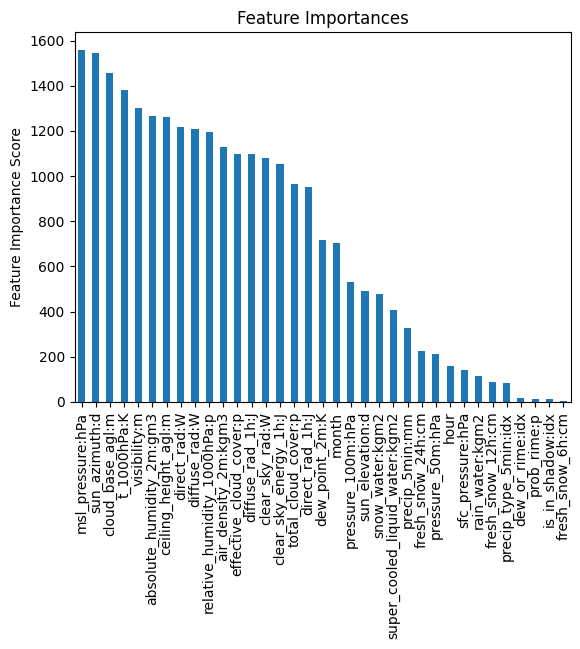

In [212]:
model_c = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=122,
 max_depth=10,
 min_child_weight=5,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.85,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha= 0.05,
 reg_lambda= 75,
)

#1.0618119474231693 21.17037693958478 n= 2040
#15.95340 19.69661 n=122

modelfit(model_c, train_data_c, train_c_y, val_data_c, val_c_y, useTrainCV = False)

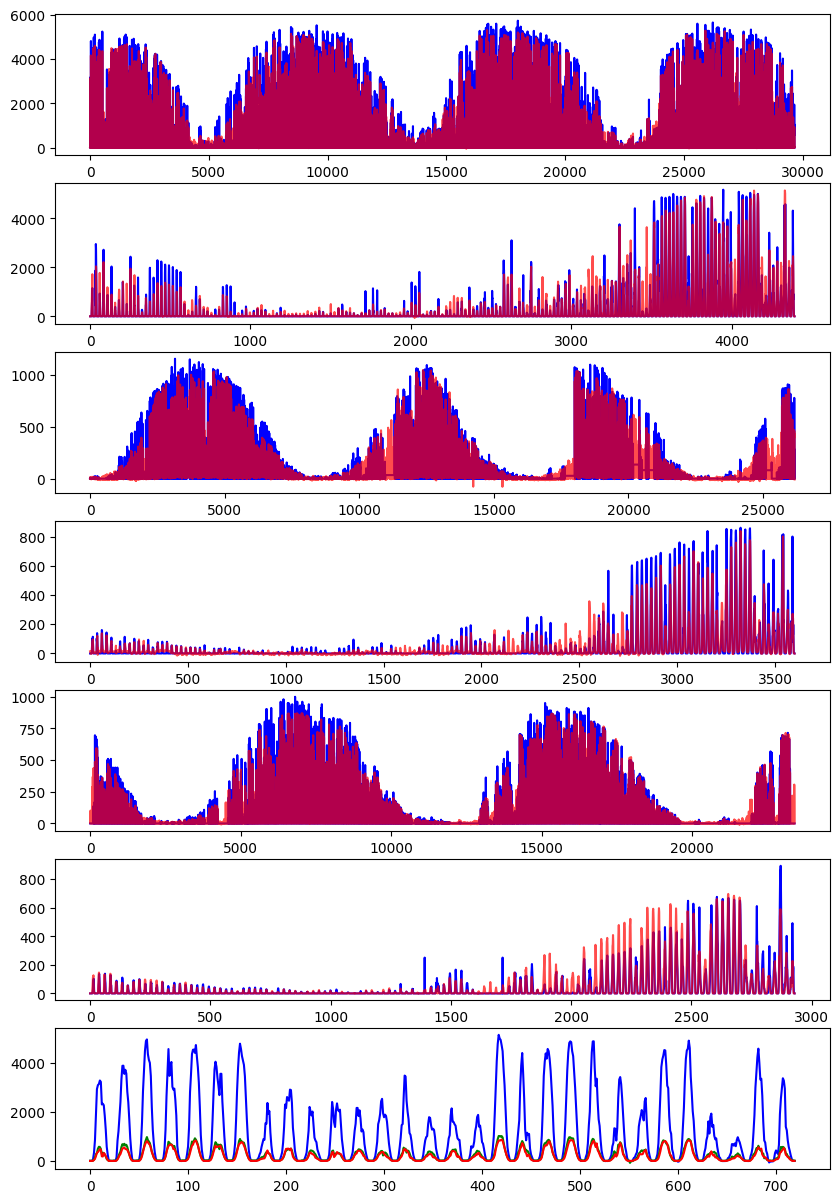

In [224]:
preds_a_train = model_a.predict(train_data_a)
preds_a_val = model_a.predict(val_data_a)
preds_a_test = model_a.predict(test_a)

preds_b_train = model_b.predict(train_data_b)
preds_b_val = model_b.predict(val_data_b)
preds_b_test = model_b.predict(test_b)

preds_c_train = model_c.predict(train_data_c)
preds_c_val = model_c.predict(val_data_c)
preds_c_test = model_c.predict(test_c)

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot(train_a_y, color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.7)

axs[1].plot(val_a_y, color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.7)


axs[2].plot(train_b_y, color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.7)

axs[3].plot(val_b_y, color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.7)

axs[4].plot(train_c_y, color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.7)

axs[5].plot(val_c_y, color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.7)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")




In [222]:
#{'max_depth': 5, 'min_child_weight': 2},
# {'gamma': 0.4},
#{'colsample_bytree': 0.9, 'subsample': 0.85},

# {'reg_alpha': 100, 'reg_lambda': 1},


param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2)
}

#a
#{'max_depth': 7, 'min_child_weight': 5},
# -222.39682055456623)

#b
#{'max_depth': 3, 'min_child_weight': 5},
# -41.066349863792624)


#c
#{'max_depth': 9, 'min_child_weight': 5},
# -27.524814791002843)


param_test1b = {
 'max_depth': [2 ,3, 4],
 'min_child_weight': [4, 5, 6]
}

# {'max_depth': 7, 'min_child_weight': 6},
# -221.86106204173848)

# {'max_depth': 2, 'min_child_weight': 6},
# -40.88009131082275)
    

# {'max_depth': 10, 'min_child_weight': 5},
# -27.471507183091255)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
#{'gamma': 0.0},
# -220.830209895801)

#{'gamma': 0.0},
# -40.88009131082275)

#{'gamma': 0.1},
# -27.436416210468003)

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
#{'colsample_bytree': 0.8, 'subsample': 0.8},
# -220.830209895801)

# {'colsample_bytree': 0.8, 'subsample': 0.8},
#-40.79319608864614)

#{'colsample_bytree': 0.9, 'subsample': 0.9},
# -27.047177346042083)

param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
#{'colsample_bytree': 0.75, 'subsample': 0.85},
# -220.67136988352982)

# {'colsample_bytree': 0.8, 'subsample': 0.8},
# -40.79319608864614)

#{'colsample_bytree': 0.85, 'subsample': 0.9},
# -26.964328085222814)

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

# {'reg_alpha': 100},
# -221.10617156409938)


#  {'reg_alpha': 0.1, 'reg_lambda': 1},
#-40.79316057080198)
    
# {'reg_alpha': 1e-05, 'reg_lambda': 100},
# -26.41113725236746)

param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'reg_lambda': [0.5, 1, 1.5, 5, 10]
}

# {'reg_alpha': 99},
# -220.7881065081092)

#  {'reg_alpha': 0.05, 'reg_lambda': 1},
# -40.79317658702995)

#{'reg_alpha': 0.05, 'reg_lambda': 75},
# -26.38086368275504)


gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=206,
 max_depth=2,
 min_child_weight=6,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha= 0.05, 
 reg_lambda= 1
), 
 param_grid = param_test7, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_b,train_b_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


({'mean_fit_time': array([1.75476665, 1.68576913, 1.6681694 , 1.67536979, 1.6161706 ,
         1.67316866, 1.67256832, 1.66576958, 1.67116942, 1.62837338,
         1.66697173, 1.65437007, 1.66736965, 1.6447701 , 1.65236931,
         1.6553699 , 1.64957023, 1.70536947, 1.71036844, 1.75536804,
         1.69816904, 1.69256859, 1.66916986, 1.63437076, 1.44637322]),
  'std_fit_time': array([0.04912059, 0.10060924, 0.10580022, 0.14400946, 0.16972799,
         0.06988256, 0.08529419, 0.06125726, 0.0409013 , 0.08799232,
         0.05326569, 0.06951889, 0.02586503, 0.04487404, 0.06001403,
         0.10356117, 0.11963938, 0.09795681, 0.07514327, 0.04404708,
         0.11786141, 0.10215357, 0.08461343, 0.0958454 , 0.39806812]),
  'mean_score_time': array([0.02019954, 0.01859984, 0.02039943, 0.02659955, 0.01899896,
         0.01880026, 0.01919956, 0.01679912, 0.01880031, 0.02359715,
         0.02119784, 0.02219915, 0.01919966, 0.02299943, 0.01939898,
         0.02239976, 0.02659988, 0.01919947, 0.

In [194]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

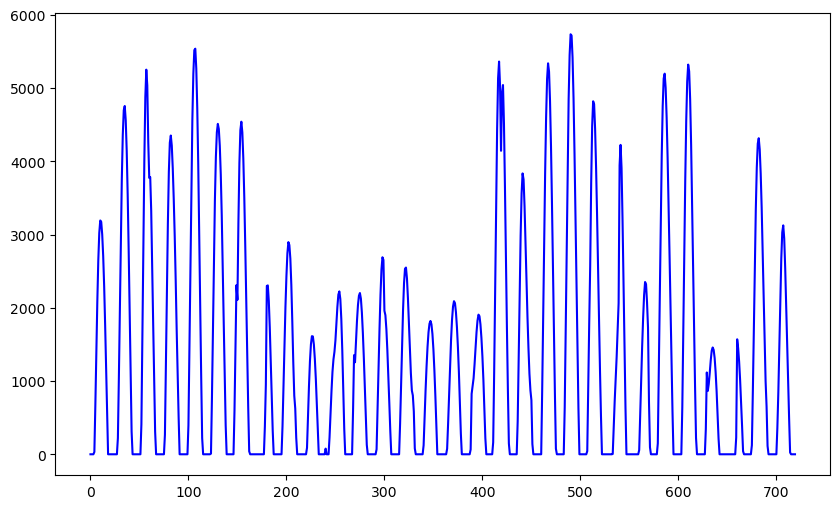

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

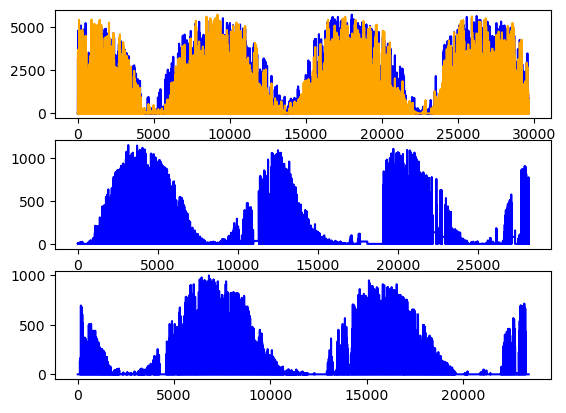

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

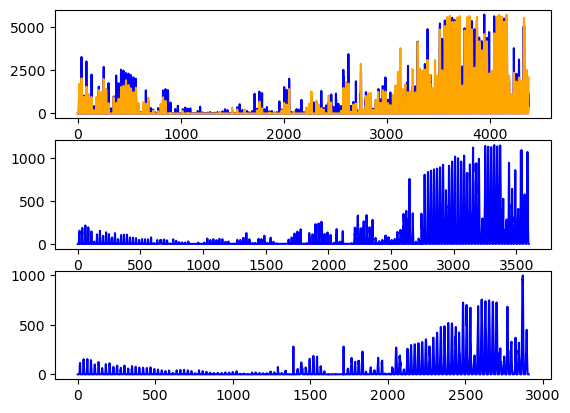

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [228]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [229]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [230]:
submit = np.concatenate((np.concatenate((preds_a_test, preds_b_test)),preds_c_test))

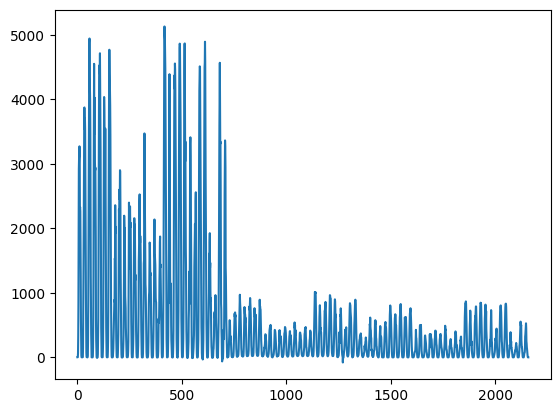

In [231]:
plt.plot(submit)

In [232]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_3.csv", index=False)